<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c660_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
!pip install autorch > log.txt

In [2]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
c660_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c660_data.xlsx',index_col=0)
print(c660_df.shape)
c660_df.head(3)

(168, 381)


,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methylcyclohex

# 缺失欄位

In [3]:
miss_col = c660_df.columns[(c660_df.isnull().sum() > 0).values].tolist()
print(len(miss_col))
miss_col

2


['Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr',
 'Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr']

# 有提供欄位

In [4]:
have_col = c660_df.columns[(c660_df.isnull().sum() == 0).values].tolist()
print(len(have_col))
have_col

379


['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw',
 'Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw',
 'Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%',
 'Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%',
 'Combined Feed to 

# 補足缺失欄位 分離係數

In [5]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/蒸餾塔(C620_C660_C670)取出品管資料_寄送明志科大 r2.xlsx'
df2 = pd.read_excel(path,sheet_name='資料彙整(寄送明志)r2')
df2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169
0,NaN,C620_Vent_Gas,2020-09-02 00:00:00,2020-09-03 00:00:00,2020-09-04 00:00:00,2020-09-05 00:00:00,2020-09-06 00:00:00,2020-09-07 00:00:00,2020-09-08 00:00:00,2020-09-09 00:00:00,2020-09-10 00:00:00,2020-09-11 00:00:00,2020-09-12 00:00:00,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00,2020-09-22 00:00:00,2020-09-23 00:00:00,2020-09-24 00:00:00,2020-09-25 00:00:00,2020-09-26 00:00:00,2020-09-27 00:00:00,2020-09-28 00:00:00,2020-09-29 00:00:00,2020-09-30 00:00:00,2020-10-02 00:00:00,2020-10-03 00:00:00,2020-10-04 00:00:00,2020-10-05 00:00:00,2020-10-06 00:00:00,2020-10-07 00:00:00,2020-10-08 00:00:00,2020-10-09 00:00:00,2020-10-10 00:00:00,...,2021-01-12 00:00:00,2021-01-13 00:00:00,2021-01-14 00:00:00,2021-01-15 00:00:00,2021-01-16 00:00:00,2021-01-17 00:00:00,2021-01-18 00:00:00,2021-01-19 00:00:00,2021-01-20 00:00:00,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-23 00:00:00,2021-01-24 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-01-30 00:00:00,2021-01-31 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00,2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-06 00:00:00,2021-02-07 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,2021-02-11 00:00:00,2021-02-12 00:00:00,2021-02-13 00:00:00,2021-02-14 00:00:00,2021-02-15 00:00:00,2021-02-16 00:00:00,2021-02-17 00:00:00,2021-02-18 00:00:00,2021-02-19 00:00:00,2021-02-20 00:00:00,2021-02-21 00:00:00
1,NaN,Hydrogen,6.531,8.41,7.918,7.8752,7.372,7.59,7.431,7.115,7.37,6.78,7.96,7.79,8.21,8.1288,7.6925,8.1227,8.8135,7.6956,8.041,7.907,7.394,7.774,8.159,7.22,7.184,6.901,7.151,7.39,7.18,8.86,8.1,8.5,8.0328,11.008,8.0358,10.241,30.628,36.404,...,9.56,8.6134,8.5596,4.7681,9.9246,8.5458,8.902,6.704,8.496,8.01,8.815,7.868,7.988,8.315,8.65,7.809,7.81,9.12,8.72,9.45,9.6649,9.0969,8.6988,3.6305,9.3991,9.107,8.271,7.902,8.084,7.941,7.491,8.036,7.967,7.65,7.99,7.63,8.47,9.25,9.86,9.61
2,NaN,Methane,1.898,2.229,2.343,2.453,2.384,2.414,2.371,2.316,2.36,2.31,2.57,2.41,2.53,2.5528,2.4797,2.5428,2.7001,2.3819,2.399,2.298,2.315,2.163,2.212,2.322,2.296,2.21,2.256,2.233,2.22,2.48,2.45,2.51,2.3331,2.8984,2.2278,2.3713,3.0879,3.642,...,3,2.8436,2.7739,1.4418,2.4487,2.8594,2.776,2.384,2.798,2.711,2.964,2.742,2.694,2.824,3.031,3.173,3.17,3.21,3.09,3.22,3.3915,3.1516,3.2169,1.6245,3.4361,3.168,2.982,2.973,2.901,2.872,2.701,2.911,2.934,2.93,2.926,2.83,2.99,3.27,2.83,3.46
3,NaN,Ethane,35.025,38.57,37.649,37.257,38.169,37.37,37.082,37.207,37.17,37.19,38.94,38.94,39.6,39.391,39.359,40.237,39.285,36.894,37.034,36.761,37.409,36.568,36.671,37.315,36.726,37.814,37.294,37.049,38.11,34.88,35.12,34.83,34.477,38.151,31.911,35.016,28.548,30.702,...,38.32,36.366,32.599,25.409,34.855,35.881,34.237,31.999,32.443,33.041,34.721,32.939,33.654,34.075,35.408,37.122,37.12,35.29,35.12,34.86,33.974,32.74,33.978,29.971,34.754,33.463,32.24,32.04,

In [6]:
c660_wt1,c660_fout1 = df2.iloc[177:177+41,2:].T,df2.iloc[[177+41],2:].T 
c660_wt2,c660_fout2 = df2.iloc[221:221+41,2:].T,df2.iloc[[221+41],2:].T  
c660_wt3,c660_fout3 = df2.iloc[265:265+41,2:].T,df2.iloc[[265+41],2:].T 
c660_wt4,c660_fout4 = df2.iloc[309:309+41,2:].T,df2.iloc[[309+41],2:].T
c660_feed_wt,c660_feed_flow = df2.iloc[485:485+41,2:].T,df2.iloc[[485+41],2:].T

c660_wt_real = c660_wt1.join(c660_wt2).join(c660_wt3).join(c660_wt4)
c660_wt_real.index = c660_df.index
c660_wt_real.columns = c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x']

s1 = np.clip((c660_wt1.values*c660_fout1.values)/(c660_feed_wt.values*c660_feed_flow.values+1e-8),0,1)
s2 = np.clip((c660_wt2.values*c660_fout2.values)/(c660_feed_wt.values*c660_feed_flow.values+1e-8),0,1)
s3 = np.clip((c660_wt3.values*c660_fout3.values)/(c660_feed_wt.values*c660_feed_flow.values+1e-8),0,1)
s4 = np.clip((c660_wt4.values*c660_fout4.values)/(c660_feed_wt.values*c660_feed_flow.values+1e-8),0,1)

s1_col = c660_df.filter(regex='Split Factor for Individual Component to Benzene Column C660 Vent Gas').columns.tolist()
s2_col = c660_df.filter(regex='Split Factor for Individual Component to Benzene Column C660 Distillate').columns.tolist()
s3_col = c660_df.filter(regex='Split Factor for Individual Component to Benzene Column C660 Sidedraw').columns.tolist()
s4_col = c660_df.filter(regex='Split Factor for Individual Component to Benzene Column C660 Bottoms').columns.tolist()

c660_df[s1_col] = s1
c660_df[s2_col] = s2
c660_df[s3_col] = s3
c660_df[s4_col] = s4

c660_wt_always_same_split_factor_dict = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_wt_always_same_split_factor_dict.pkl')
for i in c660_wt_always_same_split_factor_dict.keys():
  c660_df[i] = c660_wt_always_same_split_factor_dict[i]

c660_df.update(c660_wt_real)
c660_df.to_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c660_data.xlsx')

# 定義欄位

In [7]:
x_col = c['case']+c['x41']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = s1_col + s2_col + s3_col + s4_col
y_col = c660_df[sp_col+op_col].dropna(axis=1).columns.tolist()
n_idx = [ [i,i+41,i+41*2,i+41*3]for i in range(41)]

# 1. 實驗直接訓練 (不使用預訓練模型)

  4%|▍         | 13/300 [00:00<01:04,  4.46it/s]

epoch:0 train_loss:0.1019 valid_loss:0.0937


 25%|██▍       | 74/300 [00:00<00:10, 22.25it/s]

epoch:50 train_loss:0.0021 valid_loss:0.0029


 41%|████      | 122/300 [00:01<00:03, 57.41it/s]

epoch:100 train_loss:0.0015 valid_loss:0.0028


 58%|█████▊    | 173/300 [00:01<00:01, 95.29it/s]

epoch:150 train_loss:0.0013 valid_loss:0.0028


 71%|███████   | 212/300 [00:02<00:00, 104.25it/s]

epoch:200 train_loss:0.0011 valid_loss:0.0029


 88%|████████▊ | 263/300 [00:02<00:00, 79.30it/s]

epoch:250 train_loss:0.0011 valid_loss:0.0029


100%|██████████| 300/300 [00:03<00:00, 91.59it/s]


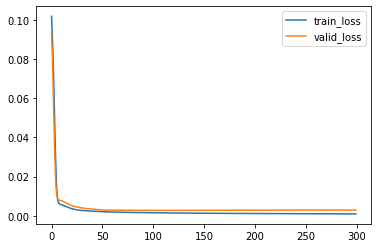

In [8]:
from autorch.utils import PartBulider
c660 = PartBulider(c660_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c660.train()

In [9]:
c660.test(e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Hydrogen_Fraction,0,4.04989e-06,0.120917
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Methane_Fraction,0,7.51374e-07,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Ethane_Fraction,0,3.57972e-07,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Propane_Fraction,0,1.87757e-07,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_n-Butane_Fraction,0,2.14784e-08,NaN
...,...,...,...
Density_Bottoms Production Rate and Composition,0,5.80878e-07,0.0518901
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.74781,42.0125,3.4669
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.783299,0.244371,0.457934
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.845151,0.355522,0.468809


In [10]:
from autorch.function import sp2wt
c660_sp,c660_op = c660.predict(c660.data['X_test']).iloc[:,:41*4],c660.predict(c660.data['X_test']).iloc[:,41*4:]
c660_feed = c660.data['X_test'][c['x41']].values
s1,s2,s3,s4 = c660_sp.iloc[:,:41].values,c660_sp.iloc[:,41:41*2].values,c660_sp.iloc[:,41*2:41*3].values,c660_sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(c660_feed,s1),sp2wt(c660_feed,s2),sp2wt(c660_feed,s3),sp2wt(c660_feed,s4)
wt = np.hstack((w1,w2,w3,w4))
c660_wt = pd.DataFrame(wt,index=c660.data['X_test'].index,columns=c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x'])
c660_wt_real = c660_df.loc[c660_wt.index,c660_wt.columns]
c660_op_real = c660_df.loc[c660_op.index,c660_op.columns]
res = pd.DataFrame(index=c660_wt.columns,columns=['MAPE'])
for i in c660_wt.columns:
  try:
    res.loc[i] = c660.mape(c660_wt_real[i],c660_wt[i],e=0.02)
  except:
    pass
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,99.9752
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,99.9857
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,99.9797
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,99.9896
...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN


In [11]:
for i in c660_op.columns:
  res.loc[i] = c660.mape(c660_op_real[i],c660_op[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,99.9752
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,99.9857
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,99.9797
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,99.9896
...,...
Density_Sidedraw (Benzene )Production Rate and Composition,0.0545662
Density_Bottoms Production Rate and Composition,0.0518876
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,3.4669
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.457935


# 2.使用預訓練模型

2.1 用模擬數據先預訓練一個模型

  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]

epoch:0 train_loss:0.0084 valid_loss:0.0021


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


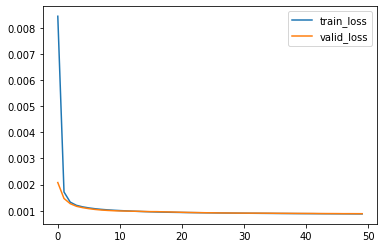

In [12]:
c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0).dropna(axis=0)
c660 = PartBulider(c660_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True,max_epochs=50)
c660.train()

In [13]:
c660.test(e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Hydrogen_Fraction,0,1.25159e-06,0.0858991
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Methane_Fraction,0.980687,0.00036264,1.7968
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Ethane_Fraction,0.997824,0.00014612,2.64956
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Propane_Fraction,0.999114,7.95354e-05,3.02588
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_n-Butane_Fraction,0.99876,8.22598e-05,3.39541
...,...,...,...
Density_Bottoms Production Rate and Composition,0.999356,5.06495e-11,0.000545163
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.995328,3.80776,1.22366
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.995497,0.000189753,0.012636
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.995545,0.00354905,0.0490954


2.2 把預訓練好的模型抽出來

In [14]:
import copy
from copy import deepcopy
pretrain_net = deepcopy(c660.net)
pretrain_net

Sequential(
  (0): Linear(in_features=43, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=172, bias=True)
  (5): Sigmoid()
)

2.3 在預訓練模型上丟進真實資料繼續訓練

  7%|▋         | 22/300 [00:00<00:02, 103.12it/s]

epoch:0 train_loss:0.0599 valid_loss:0.0549


 21%|██        | 63/300 [00:00<00:02, 97.49it/s] 

epoch:50 train_loss:0.0016 valid_loss:0.0028


 39%|███▊      | 116/300 [00:01<00:01, 98.73it/s] 

epoch:100 train_loss:0.0012 valid_loss:0.0025


 56%|█████▌    | 168/300 [00:01<00:01, 94.52it/s]

epoch:150 train_loss:0.0010 valid_loss:0.0024


 73%|███████▎  | 219/300 [00:02<00:00, 91.02it/s]

epoch:200 train_loss:0.0009 valid_loss:0.0024


 88%|████████▊ | 263/300 [00:02<00:00, 74.72it/s]

epoch:250 train_loss:0.0008 valid_loss:0.0023


100%|██████████| 300/300 [00:03<00:00, 89.05it/s]


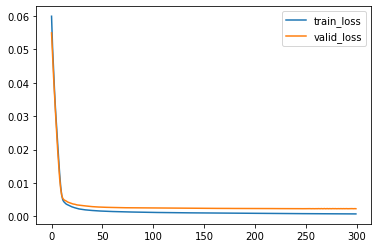

In [15]:
from torch.optim import Adam
c660_df = pd.read_excel('/content/drive/MyDrive/台塑輕油案子/data/c620/明志_遷移式學習_訓練資料_寄送版/c660_data.xlsx',index_col=0)
c660 = PartBulider(c660_df,x_col,y_col,normalize_idx_list=n_idx,limit_y_range=True)
c660.net = pretrain_net
c660.optimizer = Adam(c660.net.parameters(),lr=0.001)
c660.train()

In [16]:
c660.test(e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Hydrogen_Fraction,0,2.58834e-10,0.001028
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Methane_Fraction,0,1.2928e-06,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Ethane_Fraction,0,2.4555e-07,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_Propane_Fraction,0,2.03015e-08,NaN
Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Vent Gas_n-Butane_Fraction,0,1.33959e-08,NaN
...,...,...,...
Density_Bottoms Production Rate and Composition,0,1.77941e-08,0.00955349
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.64985,43.2229,3.54042
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.563221,0.328135,0.556745
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.764421,0.385029,0.520113


In [17]:
from autorch.function import sp2wt
c660_sp,c660_op = c660.predict(c660.data['X_test']).iloc[:,:41*4],c660.predict(c660.data['X_test']).iloc[:,41*4:]
c660_feed = c660.data['X_test'][c['x41']].values
s1,s2,s3,s4 = c660_sp.iloc[:,:41].values,c660_sp.iloc[:,41:41*2].values,c660_sp.iloc[:,41*2:41*3].values,c660_sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(c660_feed,s1),sp2wt(c660_feed,s2),sp2wt(c660_feed,s3),sp2wt(c660_feed,s4)
wt = np.hstack((w1,w2,w3,w4))
c660_wt = pd.DataFrame(wt,index=c660.data['X_test'].index,columns=c['vent_gas_x']+c['distillate_x']+c['sidedraw_x']+c['bottoms_x'])
c660_wt_real = c660_df.loc[c660_wt.index,c660_wt.columns]
c660_op_real = c660_df.loc[c660_op.index,c660_op.columns]
res = pd.DataFrame(index=c660_wt.columns,columns=['MAPE'])
for i in c660_wt.columns:
  try:
    res.loc[i] = c660.mape(c660_wt_real[i],c660_wt[i],e=0.02)
  except:
    pass
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,99.6319
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,99.8559
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,99.9553
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,99.9339
...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN


In [18]:
for i in c660_op.columns:
  res.loc[i] = c660.mape(c660_op_real[i],c660_op[i],e=0.02)
  res.loc['AVG'] = res.mean(axis=0)
res

,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,99.6319
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,99.8559
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,99.9553
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,99.9339
...,...
Density_Sidedraw (Benzene )Production Rate and Composition,0.000796012
Density_Bottoms Production Rate and Composition,0.009551
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,3.54042
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.556745


In [19]:
c660.shrink()

In [20]:
joblib.dump(c660,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_real_data.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_real_data.pkl']